In [1]:
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.applications.inception_resnet_v2 import InceptionResNetV2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size

Using TensorFlow backend.


In [2]:
X_train, y_train, X_valid, y_valid = load_data(Gray2RGB=True, 
                                               mean_proc='VGG16_ImageNet', test_size=0.1, img_size=299)

# InceptionResNetV2 Fine Tuning

In [3]:
model_name = 'InceptionResNetV2'

base_model = InceptionResNetV2(weights='imagenet', include_top=False)

x = base_model.output
x = GlobalAveragePooling2D(data_format='channels_last')(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [4]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

batch_size = 16
model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop],
                                    verbose=2)

Epoch 1/100
 - 125s - loss: 1.2216 - acc: 0.5163 - val_loss: 0.7156 - val_acc: 0.7885

Epoch 00001: val_loss improved from inf to 0.71557, saving model to ./InceptionResNetV2.h5
Epoch 2/100
 - 86s - loss: 0.5987 - acc: 0.7887 - val_loss: 0.4480 - val_acc: 0.8616

Epoch 00002: val_loss improved from 0.71557 to 0.44799, saving model to ./InceptionResNetV2.h5
Epoch 3/100
 - 88s - loss: 0.4119 - acc: 0.8561 - val_loss: 0.4108 - val_acc: 0.8590

Epoch 00003: val_loss improved from 0.44799 to 0.41084, saving model to ./InceptionResNetV2.h5
Epoch 4/100
 - 88s - loss: 0.3446 - acc: 0.8826 - val_loss: 0.3672 - val_acc: 0.8747

Epoch 00004: val_loss improved from 0.41084 to 0.36722, saving model to ./InceptionResNetV2.h5
Epoch 5/100
 - 88s - loss: 0.2933 - acc: 0.8948 - val_loss: 0.3311 - val_acc: 0.8982

Epoch 00005: val_loss improved from 0.36722 to 0.33108, saving model to ./InceptionResNetV2.h5
Epoch 6/100
 - 87s - loss: 0.2263 - acc: 0.9244 - val_loss: 0.3186 - val_acc: 0.9086

Epoch 00006:

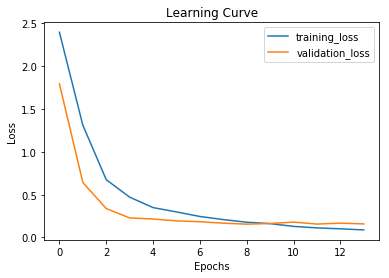

In [5]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

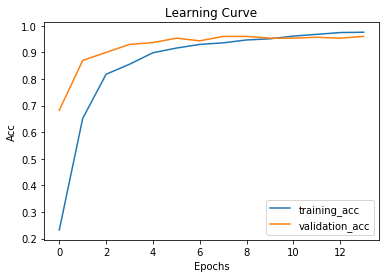

In [6]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [1]:
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.models import load_model, Model
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size

X_test, X_id = load_test_data(Gray2RGB=True, mean_proc='VGG16_ImageNet', img_size=299)

model_name = 'InceptionResNetV2'
model_path = './{}.h5'.format(model_name)
model = load_model(model_path)
y_test_pred_prob = model.predict(X_test)

y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
sub_data = pd.read_csv('submission.csv')
sub_data = sub_data.drop(["class"], axis=1)
y_test_pred_df_csv = pd.merge(sub_data, y_test_pred_df, how='left', on=['id'])
y_test_pred_df_csv.to_csv('./{}.csv'.format(model_name), index=False)
'''
scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

'''



Using TensorFlow backend.


Exception: Data must be 1-dimensional

In [2]:
y_test_pred_id = pd.DataFrame({'id': np.array(X_id)})
y_test_pred_arr = pd.DataFrame(y_test_pred_prob)
y_test_pred_id.to_csv("./{}_prob.csv".format(model_name), index=False)
y_test_pred_arr.to_csv("./{}_id.csv".format(model_name), index=False)
